In [2]:
import os
from mayavi import mlab
from tvtk.tvtk_access import tvtk
import hermes
from hermes.analysis import CoverageAnalysis, LOSAnalysis
from hermes.constellations.KuiperSystems import Kuiper_00057
from hermes.objects import Satellite
from hermes.postprocessing import generate_pass_df, generate_gap_df
from hermes.scenario import Scenario
from hermes.simulation import Simulation
from hermes.util import hex2rgb

%matplotlib inline

from astropy.coordinates import GCRS, CartesianRepresentation, ITRS, SphericalRepresentation

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from poliastro.bodies import Earth
from astropy import units as u, time
from notebooks.PlotUtil import apply_report_formatting

import cartopy.crs as ccrs

mlab.init_notebook('ipy', local=True)

# PDF exporter defaults
ex = tvtk.GL2PSExporter()
ex.file_format = 'pdf'
ex.sort = 'bsp'
ex.compress = 1
#ex.edit_traits(kind='livemodal')

figures_dir = 'D:/git/thesis_report_ae/figures/visibility_analysis'

Notebook initialized with ipy backend.


### Kuiper 00057 spatial coverage
This runs a spatial coverage simulation and analysis at several altitudes using the
``hermes.analysis.CoverageAnalysis`` class.

In [3]:
def run_spatial_coverage_simulation():

    start = time.Time('2019-09-01 10:00:00.000', scale='tt')        # Start time of simulation
    stop = time.Time('2019-09-07 10:00:00.000', scale='tt')         # Stop time of simulation
    step = 1 * u.s

    scenario = Scenario(start, stop, step, hermes.objects.Earth, name='Kuiper')

    # Make a new Satellite object and give it a cyan color
    sat_400_51 = Satellite.circular(hermes.objects.Earth.poli_body, 400 * u.km, inc=51.6 * u.deg, raan=0 * u.deg, arglat=0 * u.deg)
    sat_400_51.color = hex2rgb('#00ffff')
    sat_400_51.name = 'sat_400km_51deg'
    #sat_400_51.J2_perturbation = True

    sat_500_97 = Satellite.circular(hermes.objects.Earth.poli_body, 500 * u.km, inc=97.5 * u.deg, raan=0 * u.deg, arglat=0 * u.deg)
    sat_500_97.color = hex2rgb('#00ffff')
    sat_500_97.name = 'sat_500km_97deg'
    #sat_500_97.J2_perturbation = True

    # And we add it to the scenario
    scenario.add_satellite(sat_400_51)
    scenario.add_satellite(sat_500_97)

    # Constellation
    constellation = Kuiper_00057
    scenario.add_satellite(constellation)

    # # Activate FOV
    # import itertools
    # for sat in itertools.islice(constellation, 80):
    #     sat.fov_3D_show = True

    # Add line-of-sight analysis
    # analysis = CoverageAnalysis(scenario, constellation, altitude=1300 * u.km)
    # scenario.add_analysis(analysis)

    analysis = CoverageAnalysis(scenario, constellation, altitude=1000 * u.km)
    scenario.add_analysis(analysis)

    analysis = CoverageAnalysis(scenario, constellation, altitude=750 * u.km)
    scenario.add_analysis(analysis)

    analysis = CoverageAnalysis(scenario, constellation, altitude=500 * u.km)
    scenario.add_analysis(analysis)

    analysis = CoverageAnalysis(scenario, constellation, altitude=400 * u.km)
    scenario.add_analysis(analysis)

    # analysis = CoverageAnalysis(scenario, constellation, altitude=200 * u.km)
    # scenario.add_analysis(analysis)

    # Initialise the scenario
    scenario.initialise()

    output_tuples = [None] * len(scenario.state.analyses)

    if not os.path.exists('raw_data'):
        os.makedirs('raw_data')

    for i, analysis in enumerate(scenario.state.analyses):
        writer = analysis.generate_writer(directory = 'raw_data')
        writer.initialise()
        writer.flush()
        output_tuples[i] = (writer.file_path, '%dkm' % analysis.altitude.to(u.km).value)
        del writer

    return output_tuples, scenario

from os import path
import pickle

if path.isfile('coverage_simulation.p'):
    coverage_list, scenario = pickle.load(open('coverage_simulation.p', 'rb'))
else:
    coverage_list, scenario = run_spatial_coverage_simulation()
    pickle.dump((coverage_list, scenario), open('coverage_simulation.p', 'wb'))

Initializing attractor
Initializing 3238 satellites...
Initializing analysis 1 of 4...
Initializing analysis 2 of 4...
Initializing analysis 3 of 4...
Initializing analysis 4 of 4...


In [4]:
# Not working in Pycharm, but works in the browser

vis = scenario.visualise3D()
vis.figure

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\xb0\x00\x00\x04\xb0\x08\x02\x00\x00\x00dC$\x98\x…

C:\git\hermes-simulator\cenv\lib\site-packages\matplotlib\contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\git\hermes-simulator\cenv\lib\site-packages\matplotlib\contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\git\hermes-simulator\cenv\lib\site-packages\matplotlib\contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\git\hermes-simulator\cenv\lib\site-packages\matplotlib\contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


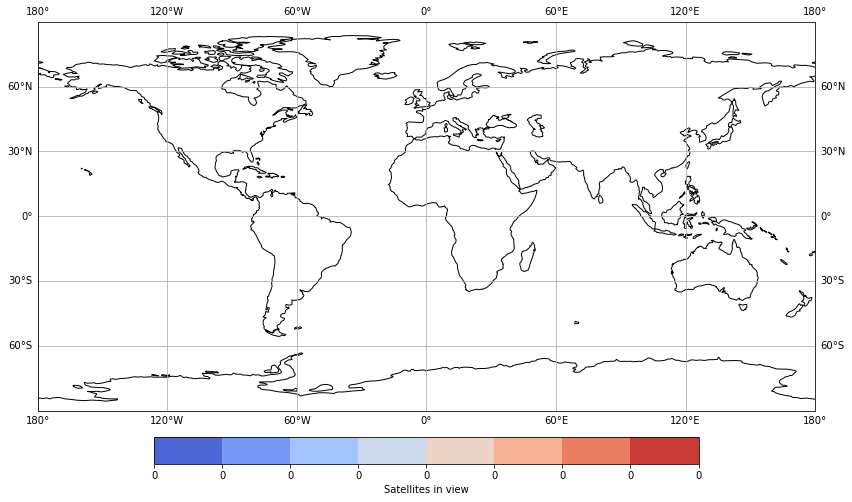

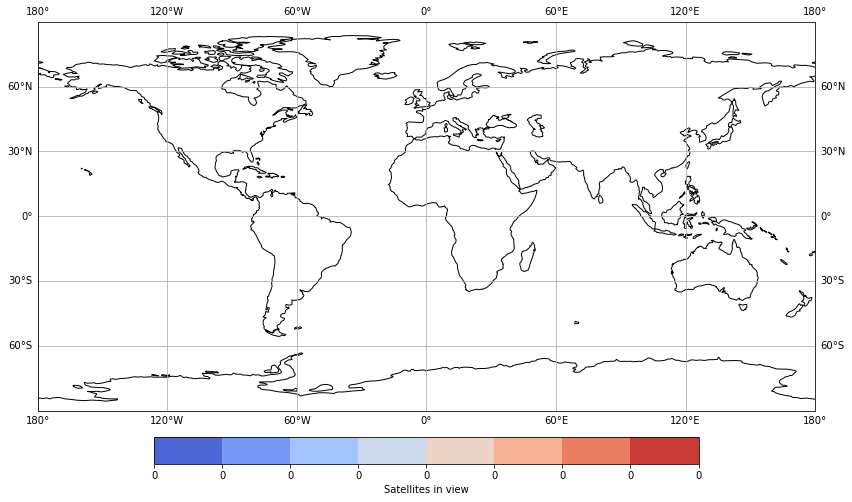

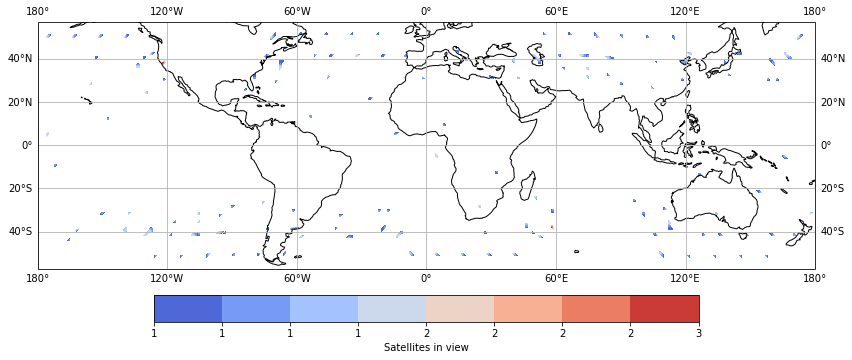

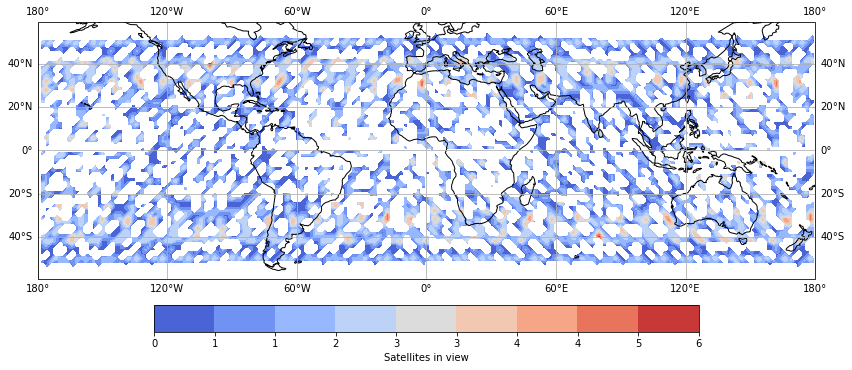

In [5]:
def plot_coverage_spatial(coverage_df):

    # Calculate lat longs
    epoch = time.Time('J2017', scale='tt')
    obs_times = epoch + coverage_df['tof'].values * u.s
    gcrs_xyz = GCRS(x=coverage_df['r_x'], y=coverage_df['r_y'], z=coverage_df['r_z'],
                    obstime=obs_times, representation_type=CartesianRepresentation)
    itrs_xyz = gcrs_xyz.transform_to(ITRS(obstime=obs_times))
    itrs_latlon = itrs_xyz.represent_as(SphericalRepresentation)

    coverage_df['r_lat'] = itrs_latlon.lat.to(u.deg)
    coverage_df['r_lon'] = ((itrs_latlon.lon + np.pi * u.rad) % (2*np.pi * u.rad) - np.pi * u.rad).to(u.deg)

    ## Plotting
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes([0.1,0.1,.9,.9], projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    step = 1
    llon = np.arange(-180, 180 + step, step)
    llat = np.arange(-90, 90 + step, step)

    # Set zero to NaN so it isn't accounted in the contour plot
    coverage_df.loc[coverage_df['num_los'] == 0, 'num_los'] = np.nan

    from scipy.interpolate import griddata
    val = griddata((coverage_df['r_lon'], coverage_df['r_lat']), coverage_df['num_los'],
                   (llon[None,:], llat[:,None]), method='linear')
    #val = np.floor(val)

    # define the bins and normalize
    import copy
    cmap = copy.copy(plt.get_cmap('coolwarm'))  # define the colormap
    cmap.set_bad(color=(.5, .5, .5), alpha=1)

    im = ax.contourf(llon, llat, val, cmap=cmap)

    cax, kw = matplotlib.colorbar.make_axes(ax, location='bottom',pad=0.05,shrink=0.7)

    out = fig.colorbar(im,
                       cax=cax,
                       #spacing='proportional',
                       #ticks=bounds,
                       format='%1i',
                       label='Satellites in view',
                       **kw)

for coverage_item in coverage_list:
    columns = ['tof', 'r_x', 'r_y', 'r_z', 'num_los']
    store = pd.HDFStore(coverage_item[0])
    coverage_df = store.select('coverage', 'columns = %s' % str(columns))
    plot_coverage_spatial(coverage_df)
    #plt.title(coverage_item[1])
    #plt.savefig(figures_dir + '/OneWeb_spatial_coverage_%s.svg' % coverage_item[1])
    #plt.savefig(figures_dir + '/OneWeb_spatial_coverage_%s.pgf' % coverage_item[1])
    plt.savefig(figures_dir + '/Kuiper_spatial_coverage_%s.pdf' % coverage_item[1])
    plt.show()

### Kuiper 00057 Contact simulation

In [6]:
start = time.Time('2019-09-01 10:00:00.000', scale='tt')        # Start time of simulation
stop = time.Time('2019-09-07 10:00:00.000', scale='tt')         # Stop time of simulation
step = 1 * u.s

scenario = Scenario(start, stop, step, hermes.objects.Earth, name='Kuiper')

# Make a new Satellite object and give it a cyan color
sat_400_51 = Satellite.circular(hermes.objects.Earth.poli_body, 400 * u.km, inc=51.6 * u.deg, raan=0 * u.deg, arglat=0 * u.deg)
sat_400_51.color = hex2rgb('#00ffff')
sat_400_51.name = 'sat_400km_51deg'
#sat_400_51.J2_perturbation = True

sat_500_97 = Satellite.circular(hermes.objects.Earth.poli_body, 500 * u.km, inc=97.5 * u.deg, raan=0 * u.deg, arglat=0 * u.deg)
sat_500_97.color = hex2rgb('#00ffff')
sat_500_97.name = 'sat_500km_97deg'
#sat_500_97.J2_perturbation = True

# And we add it to the scenario
scenario.add_satellite(sat_400_51)
scenario.add_satellite(sat_500_97)

# Add the constellation
constellation = Kuiper_00057
scenario.add_satellite(constellation)

# Add line-of-sight analysis
scenario.add_analysis(LOSAnalysis(scenario, sat_400_51, constellation))
scenario.add_analysis(LOSAnalysis(scenario, sat_500_97, constellation))

# Initialise the scenario
scenario.initialise()

simulation = Simulation(scenario, show_3d=False)
simulation.run()

Initializing attractor
Initializing 3238 satellites...
Initializing analysis 1 of 2...
Initializing analysis 2 of 2...


Simulation progress: 100%|██████████| 518400/518400 [47:16<00:00, 182.74it/s]  


In [16]:
columns = ['strand_name', 'tof', 'r_a_x', 'r_a_y', 'r_a_z', 'r_b_x', 'r_b_y', 'r_b_z']

store_500km = pd.HDFStore("2021-02-14_20-19-13_Kuiper_LOSAnalysis_sat_500km_97deg_to_node.h5")
instances_500km_df = store_500km.select('contact_instances', 'columns = %s' % str(columns))

In [17]:
store_400km = pd.HDFStore("2021-02-14_20-19-10_Kuiper_LOSAnalysis_sat_400km_51deg_to_node.h5")
instances_400km_df = store_400km.select('contact_instances', 'columns = %s' % str(columns))

In [18]:
pass_500km_df = generate_pass_df(instances_500km_df)
gaps_500km_df = generate_gap_df(instances_500km_df)

pass_400km_df = generate_pass_df(instances_400km_df)
gaps_400km_df = generate_gap_df(instances_400km_df)

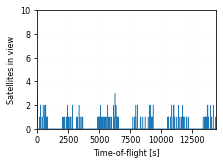

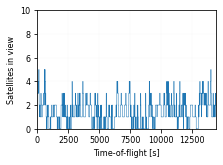

In [19]:
def contact_timeline(pass_df):
    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    tof_max = (4 * u.hour).to(u.s).value

    tofs = np.arange(tof_max)

    def satellites_in_view(pass_df, tofs):
        num_in_view = np.zeros((len(tofs), ))
        for i, tof in enumerate(tofs):
            in_view = (pass_df['start_tof'] <= tof) & (tof <= pass_df['end_tof'])
            num_in_view[i] = in_view.sum()
        return num_in_view

    ax.step(tofs, satellites_in_view(pass_df, tofs), linewidth=0.5)
    ax.set_xlim((0, tof_max))
    ax.set_ylim((0, 10))
    ax.set_xlabel('Time-of-flight [s]')
    ax.set_ylabel('Satellites in view')
    ax.grid(linestyle=':', linewidth = 0.1)
    apply_report_formatting()

    #plt.show()

contact_timeline(pass_500km_df)
plt.savefig(figures_dir + '/Kuiper_in_view_500km97deg.pdf')
plt.show()

contact_timeline(pass_400km_df)
plt.savefig(figures_dir + '/Kuiper_in_view_400km51deg.pdf')
plt.show()

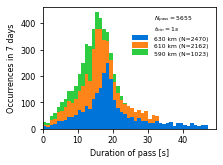

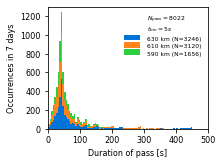

In [28]:
def plot_pass_temporal_distribution(pass_df, bin_size = 5.0):

    durations_np = pass_df.duration.to_numpy()

    bins = int(np.max(durations_np))
    bins = int(bins / bin_size) # x second bins
    count = len(durations_np)

    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    ax.plot(np.NaN, np.NaN, '-', color='none', label='$N_{pass} = %d$' % (count))
    ax.plot(np.NaN, np.NaN, '-', color='none', label='$t_{bin} = %ds$' % (bin_size))

    # Split into polar and inclined orbits
    r630_sat = np.isclose(pass_df.r_b_norm - Earth.R_mean.to(u.m).value, 630*1000, atol=100)
    r610_sat = np.isclose(pass_df.r_b_norm - Earth.R_mean.to(u.m).value, 610*1000, atol=100)
    r590_sat = np.isclose(pass_df.r_b_norm - Earth.R_mean.to(u.m).value, 590*1000, atol=100)

    durations_np = [durations_np[r630_sat], durations_np[r610_sat], durations_np[r590_sat]]

    n, bins, patches = ax.hist(durations_np,
                               bins=bins,
                               histtype='bar',
                               stacked=True,
                               color=["#0074D9", "#FF851B", "#2ECC40"],
                               label=['630 km (N=%d)' % r630_sat.sum(),
                                      '610 km (N=%d)' % r610_sat.sum(),
                                      '590 km (N=%d)' % r590_sat.sum()])

    ax.set_xlabel('Duration of pass [s]')
    ax.set_ylabel('Occurrences in 7 days')
    ax.set_xlim((0, ax.get_xlim()[1]))

    ax.legend(loc='upper right', frameon=False, labelspacing=0.1, fontsize=8)

    return ax

plot_pass_temporal_distribution(pass_500km_df, bin_size=1.0)
apply_report_formatting()
plt.savefig(figures_dir + '/Kuiper_pass_distribution_500km97deg.pdf')
plt.show()

ax = plot_pass_temporal_distribution(pass_400km_df, bin_size=5.0)
ax.set_xlim((0, 500))
apply_report_formatting()
plt.savefig(figures_dir + '/Kuiper_pass_distribution_400km51deg.pdf')
plt.show()

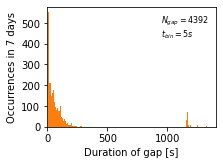

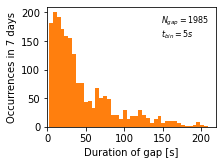

In [21]:
def plot_gap_temporal_distribution(gaps_df, bin_size = 5.0):

    durations_np = gaps_df.duration.to_numpy()
    count = len(durations_np)

    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    ax.plot(np.NaN, np.NaN, '-', color='none', label='$N_{gap} = %d$' % (count))
    ax.plot(np.NaN, np.NaN, '-', color='none', label='$t_{bin} = %ds$' % (bin_size))

    ax.set_xlabel('Duration of gap [s]')
    ax.set_ylabel('Occurrences in 7 days')
    ax.legend(loc='upper right', frameon=False, labelspacing=0.1, fontsize=8)

    if len(durations_np) == 0:
        ax.text(0.5, 0.50,
            'No gaps',
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax.transAxes)
        ax.set_xlim((0,1))
        ax.set_ylim((0,1))

        return

    bins = int(np.max(durations_np))
    bins = int(bins / bin_size) # x second bins

    n, bins, patches = ax.hist(durations_np,
                               bins=bins,
                               stacked=True,
                               color = "tab:orange",
                               lw=0,
                               label='Gaps')


    ax.set_xlim((0, ax.get_xlim()[1]))

    average = np.average(durations_np)
    std_dev = np.std(durations_np)

    return ax

plot_gap_temporal_distribution(gaps_500km_df)
plt.savefig(figures_dir + '/Kuiper_gap_distribution_500km97deg.pdf')
plt.show()

plot_gap_temporal_distribution(gaps_400km_df)
plt.savefig(figures_dir + '/Kuiper_gap_distribution_400km51deg.pdf')
plt.show()

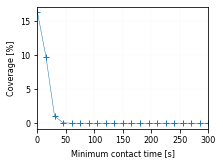

15s, 9.7%
30s, 1.0%
60s, 0.0%
150s, 0.0%
300s, 0.0%


15s, 81.2%
30s, 76.5%
60s, 45.5%
150s, 16.7%
300s, 5.5%




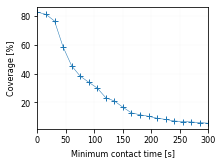

In [22]:
def plot_temporal_coverage(instances_df, pass_df, tof_end = None, min_durations=np.arange(0, 315, 15)):

    if tof_end is None:
        tof_end = max(instances_df['tof'])

    percentages = np.zeros((len(min_durations),))

    for i, min_duration in enumerate(min_durations):

        # First we find which passes are long enough to include:
        long_passes = pass_df[pass_df.duration >= min_duration]

        # And use that to filter the instances
        long_instances_df = instances_df[instances_df.index.isin(long_passes.index, level='p')]

        if long_instances_df.size > 0:
            # Then we compute the gaps
            long_gap_df = generate_gap_df(long_instances_df, tof_end=tof_end)

            # Then we compute the total gap duration
            total_gap_duration = long_gap_df[long_gap_df['end_tof'] <= tof_end].duration.sum()

            # And compute the coverage percentage
            percentages[i] = 1 - min(1, total_gap_duration / tof_end)
        else:
            percentages[i] = 0

    ## DO PLOTTING
    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))
    ax.plot(min_durations, percentages * 100, '-+', linewidth=0.5)
    ax.set_xlabel('Minimum contact time [s]')
    ax.set_ylabel('Coverage [%]')
    ax.grid(linestyle=':', linewidth=0.1)
    ax.set_xlim((0, max(min_durations)))
    apply_report_formatting()

    return min_durations, percentages

min_durations, percentages = plot_temporal_coverage(instances_500km_df, pass_500km_df)
plt.savefig(figures_dir + '/Kuiper_coverage_vs_time_500km97deg.pdf')
plt.show()

interp_durations = [15, 30, 60, 150, 300]
interp_percentages = np.interp(interp_durations, min_durations, percentages)

for d, p in zip(interp_durations, interp_percentages):
    print("%ds, %0.1f%%" % (d, p * 100))
print("\n")


min_durations, percentages = plot_temporal_coverage(instances_400km_df, pass_400km_df,)
plt.savefig(figures_dir + '/Kuiper_coverage_vs_time_400km51deg.pdf')
plt.show()

interp_percentages = np.interp(interp_durations, min_durations, percentages)

for d, p in zip(interp_durations, interp_percentages):
    print("%ds, %0.1f%%" % (d, p * 100))
print("\n")